In [56]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.despine()

<Figure size 432x288 with 0 Axes>

In [57]:
weather_df = pd.read_csv('1643302.csv')

city_df = pd.read_csv('csv-zusammenfuehren.de_7gr2scwy.csv')
city_df["AMOUNT"]=city_df["AMOUNT"].str.replace(',','')
city_df["AMOUNT"]=pd.to_numeric(city_df["AMOUNT"])

In [58]:
# cleaning the data of NAN values
# this removes ~96% of the data (snowfall and snow depth is not recorded hourly)
# data internally uses T to represent no snowfall, we will remove that as well

weather_df['DailySnowfall'].replace('T', np.nan, inplace=True)
weather_df.dropna(subset=['DailySnowfall'], inplace=True)

weather_df['DailySnowDepth'].replace('T', np.nan, inplace=True)
weather_df.dropna(subset=['DailySnowDepth'], inplace=True)

# converting the columns to numeric from object type

weather_df["DailySnowfall"]=pd.to_numeric(weather_df["DailySnowfall"], errors='ignore')
weather_df["DailySnowDepth"]=pd.to_numeric(weather_df["DailySnowDepth"], errors='ignore')

# slicing date to add a new column year
weather_df['YEAR']=weather_df['DATE'].str.slice(start=0, stop=4)

concatenated=pd.concat([weather_df.assign(dataset="weather_df"), city_df.assign(dataset="city_df")], sort=False)
city_df

,ORG,OBJECT,PROJECT,ACCOUNT,DESCRIPTION,YEAR,PER,JOURNAL,EFF DATE,SRC,T,REF1,PO/REF2,REF3,REFERENCE,AMOUNT
0,44330,57141,0,1100-40-44-443-4430-0000-00000-00000-57141-00000,ST SN PLOW ID CHRG FS,2015,12,"3,750",12/30/2015,GEN,1.0,NaN,NaN,NaN,FS CHRGS,650676.00
1,44331,57141,0,1100-40-44-443-4431-0000-00000-00000-57141-00000,ST SN REMV ID CHRG FS,2015,12,"3,750",12/30/2015,GEN,1.0,NaN,NaN,NaN,FS CHRGS,95601.00
2,44332,57141,0,1100-40-44-443-4432-0000-00000-00000-57141-00000,ST SN CROS ID CHRG FS,2015,12,"3,750",12/30/2015,GEN,1.0,NaN,NaN,NaN,FS CHRGS,95601.00
3,44335,57141,0,1100-40-44-443-4435-0000-00000-00000-57141-00000,ST SN BUS ID CHRG FS,2015,12,"3,750",12/30/2015,GEN,1.0,NaN,NaN,NaN,FS CHRGS,18532.00
4,44332,51120,0,1100-40-44-443-4432-0000-00000-00000-51120-00000,ST SN CROS PRMIUM PAY,2015,12,"3,489",12/31/2015,GNI,1.0,NaN,NaN,NaN,RCL930-938,-850.42
5,44331,51140,0,1100-40-44-443-4431-0000-00000-00000-51140-00000,ST SN REMV COMP ABSNC,2015,12,"3,489",12/31/2015,GNI,1.0,NaN,NaN,NaN,RCL930-938,850.42
6,44332,51140,0,1100-40-44-443-4432-0000-00000-00000-51140-00000,ST SN CROS COMP ABSNC,2015,12,"3,489",12/31/2015,GNI,1.0,NaN,NaN,NaN,RCL930-938,850.42
7,44330,51110,0,1100-40-44-443-4430-0000-00000-00000-51110-00000,ST SN PLOW PERM WAGES,2015,12,"3,489",12/31/2015,GNI,1.0,NaN,NaN,NaN,RCL930-938,-7486.88
8,44301,51120,0,1100-40-44-443-4401-0000-00000-00000-51120-00000,SW ADM PRMIUM PAY,2015,12,"3,489",12/31/2015,GNI,1.0,NaN,NaN,NaN,RCL930-938,-8507.39
9,44301,51140,0,1100-40-44-443-4401-0000-00000-00000-51140-00000,SW ADM COMP ABSNC,2015,12,"3,489",12/31/2015,GNI,1.0,NaN,NaN,NaN,RCL930-938,8507.39


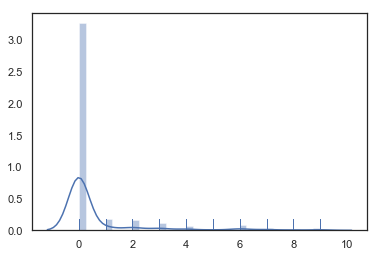

In [107]:
# lets look at the shape of the distribution of both snowfall and snow depth
val = weather_df['DailySnowDepth'].values
sns.distplot(val, rug=True, color="b")
#weather_df['DailySnowDepth'].values

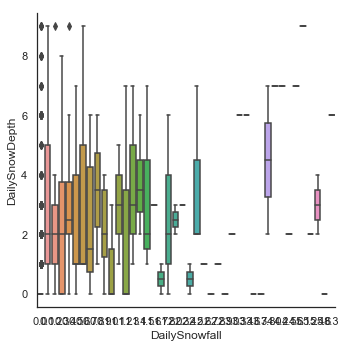

In [108]:
# 3 quartile variations of daily snowfall shown inside box
# whiskers extend to points within 1.5 inter quartiles of lower and upper bounds
# can see that there is a wide variation of snow depths that correspond to amount of daily snowfall
# there is unlikely to be much correlation

sns.catplot(x="DailySnowfall", y="DailySnowDepth", kind="box", data=weather_df)
plt;

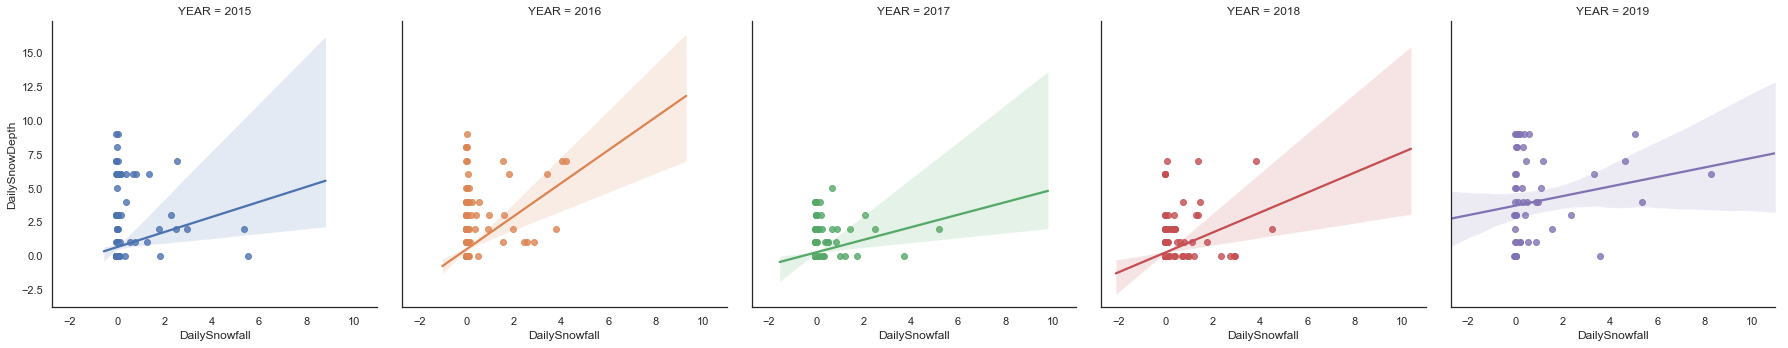

In [109]:
# just to be sure there isn't much correlation, let us look at a scatterplot of daily snowfall vs snow depth
# we can see that there is a lot of variation in this data

ax = sns.lmplot(x="DailySnowfall", y="DailySnowDepth", data=weather_df, x_jitter=0.05, hue='YEAR', ci=95, col="YEAR")
plt;

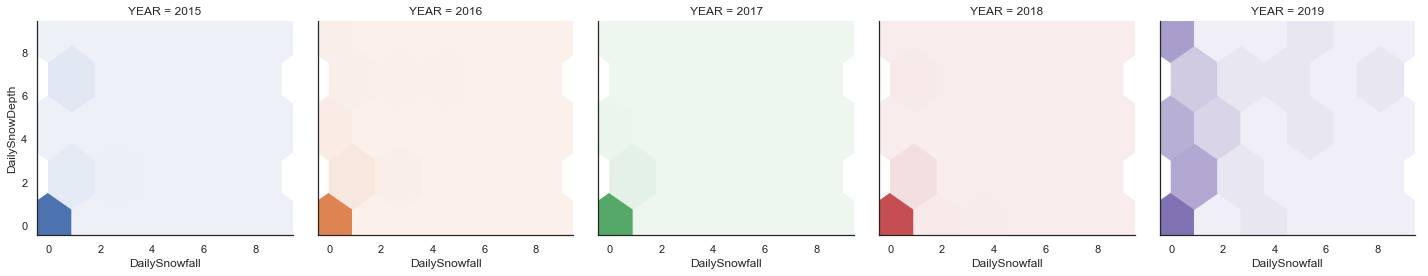

In [81]:
# thinking of different ways to visualize distribution data
# snowfall depth and daily snowfall placed in hexbins
# intensity of color corresponds to frequency
# 2019 is most random due to erratic snowfall
# seems like in 2019, snow depth accumulated due to continuous snowfall
# snowfall seemeds to be less on a single day and more dispersed in other years

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True, n_colors=100)
    plt.hexbin(x, y, gridsize=5, cmap=cmap, **kwargs)

with sns.axes_style("white"):
    g = sns.FacetGrid(weather_df, hue="YEAR", col="YEAR", height=4)
g.map(hexbin, "DailySnowfall", "DailySnowDepth", extent=[0,9, 0,9]);

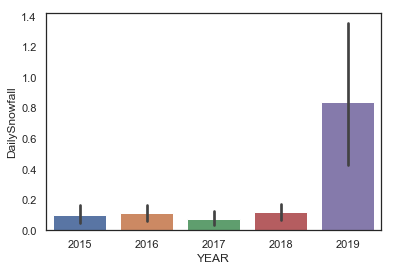

In [84]:
# lets plot the average daily snowfall for each year
# this will help us determine which years the city had to plow more intensely
# (as a high daily snowfall leads to more accumulated snow after the previous plowing)

sns.barplot(x='YEAR', y='DailySnowfall', data=weather_df)

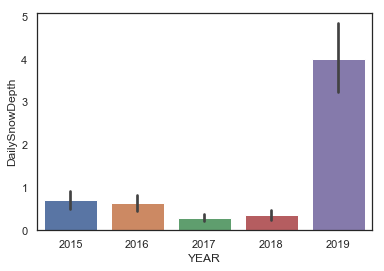

In [85]:
# lets plot the average daily snowdepth for each year
# this will also help us determine which years the city had to plow more intensely
# hopefully 2019 should be the highest again as it should have the highest snowdepth due to rapid bursts of snowfall

sns.barplot(x='YEAR', y='DailySnowDepth', data=weather_df)

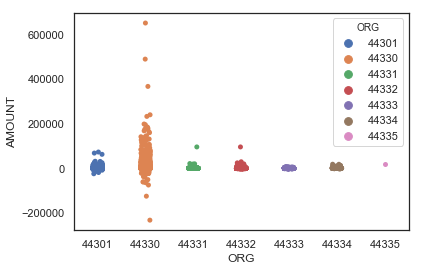

In [71]:
# plotting distribution of city data
# want to see if there is a large deviation of amount spent in transactions by a department
# we can clearly see that there is a large spread for org 44330 (Plowing)

sns.stripplot(x="ORG", y="AMOUNT", hue="ORG", data=city_df);

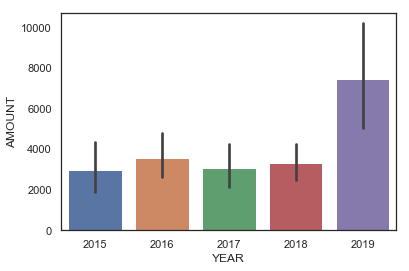

In [80]:
# lets focus closer on this department
# is there a large variation per year?
# we are plotting the average value of each plowing transaction per year
# the lines correspond to error bars that give us some insight about the uncertainity regarding each value

plow_df = city_df.loc[city_df['ORG'] == 44330]
sns.barplot(x='YEAR', y='AMOUNT', data=plow_df)

# this is good since 2019 is the highest
# remember that 2019 had the highest average snowfall and snowdepth as well
# thus there seems to be a correlation between amount spent on plowing and snowfall